# PyTorch Variational Autoencoder  MNIST  

参考  
https://github.com/pytorch/examples/blob/master/vae/main.py  
https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py

In [0]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import os

## データ読み込み

In [0]:
# GPUが利用可能か確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128

train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27906943.30it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 440402.19it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145329.47it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 7575708.49it/s]                            
8192it [00:00, 180357.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
print('Number of train samples: ', len(train_dataset))
print('Number of test samples: ', len(test_dataset))

Number of train samples:  60000
Number of test samples:  10000


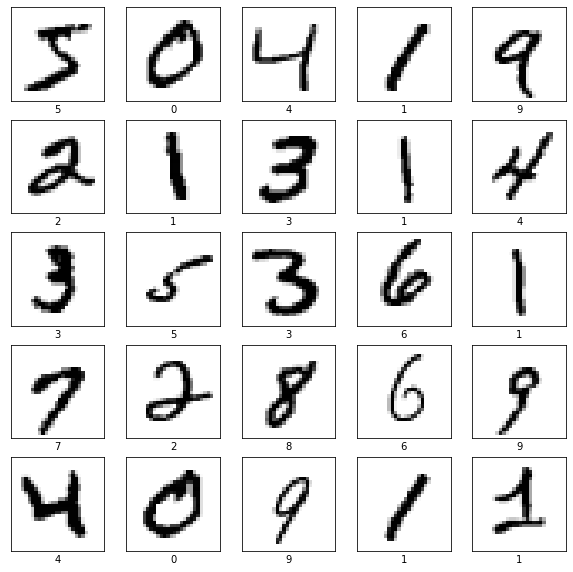

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i + 1)
    plt.xticks([])
    plt.yticks([]) 
    plt.grid('off')
    plt.imshow(train_dataset[i][0].squeeze(0).cpu().numpy(), cmap=plt.cm.binary)
    plt.xlabel(train_dataset[i][1])

## モデルを作成
### Data & Network Parames


In [0]:
image_size = train_dataset[0][0].size()[1] #28
original_dim = image_size * image_size

In [0]:
# network parameters
input_size = original_dim
intermediate_dim = 512
latent_dim = 2
epochs = 50

## VAE model

### Encoder module

In [0]:
class Encoder(nn.Module):
    def __init__(self,D_in, H, D_out):
        super(Encoder,self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear21 = nn.Linear(H, D_out)
        self.linear22 = nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu = self.linear21(x)
        log_var = self.linear22(x)
        return mu, log_var

### Decoder module

In [0]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return torch.sigmoid(self.linear2(x))

### VAE module

In [0]:
class VAE(torch.nn.Module):
 
    def __init__(self, encoder, decoder,latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(intermediate_dim, latent_dim)
        self._enc_log_sigma = torch.nn.Linear(intermediate_dim, latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, state):
        mu, log_var = self.encoder(state.view(-1, input_size))

        z = self.reparameterize(mu,log_var)
        return self.decoder(z), mu, log_var


### Define Loss Function

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Define Train and Evaluation Function

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss  /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    
    return train_loss

In [0]:
def test(epoch):
    model.eval()
    test_loss = 0
    data_list=[]
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            data_list.append(recon_batch)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 2)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, image_size, image_size)[:n]])
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss 

#### VAE Modelをインスタンス化

In [0]:
encoder= Encoder(784,400,latent_dim)
decoder= Decoder(latent_dim,400,784)
# VAEクラスのインスタンスを生成
model = VAE(encoder,decoder).to(device)
# optimizerの定義
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train

In [0]:
train_loss_list=[]
test_loss_list=[]

for epoch in range(1,epochs+1):
    train_loss_list.append(train(epoch))
    test_loss_list.append(test(epoch))

====> Epoch: 1 Average loss: 192.2266
====> Test set loss: 172.4345
====> Epoch: 2 Average loss: 169.2770
====> Test set loss: 165.5460
====> Epoch: 3 Average loss: 164.1497
====> Test set loss: 162.1906
====> Epoch: 4 Average loss: 161.1448
====> Test set loss: 160.0637
====> Epoch: 5 Average loss: 159.1002
====> Test set loss: 158.2604
====> Epoch: 6 Average loss: 157.6482
====> Test set loss: 156.9837
====> Epoch: 7 Average loss: 156.4433
====> Test set loss: 156.4259
====> Epoch: 8 Average loss: 155.4518
====> Test set loss: 155.4786
====> Epoch: 9 Average loss: 154.6729
====> Test set loss: 154.7734
====> Epoch: 10 Average loss: 153.9258
====> Test set loss: 154.4163
====> Epoch: 11 Average loss: 153.2849
====> Test set loss: 153.7368
====> Epoch: 12 Average loss: 152.6378
====> Test set loss: 153.2609
====> Epoch: 13 Average loss: 152.1257
====> Test set loss: 152.8448
====> Epoch: 14 Average loss: 151.6252
====> Test set loss: 152.6434
====> Epoch: 15 Average loss: 151.1652
====

In [0]:
# 学習済みモデルを保存
torch.save(model.state_dict(), 
           'vae_mlp_mnist.pth')

#### epochごとの訓練損失とバリデーション損失を可視化

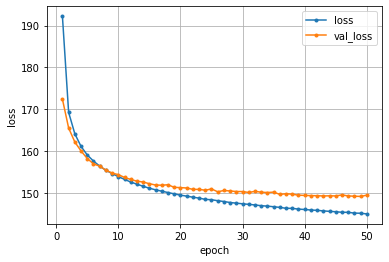

In [0]:
plt.plot(range(1,epochs+1), train_loss_list, marker='.', label='loss')
plt.plot(range(1,epochs+1), test_loss_list, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 結果を可視化

#### VAEで、画像を生成

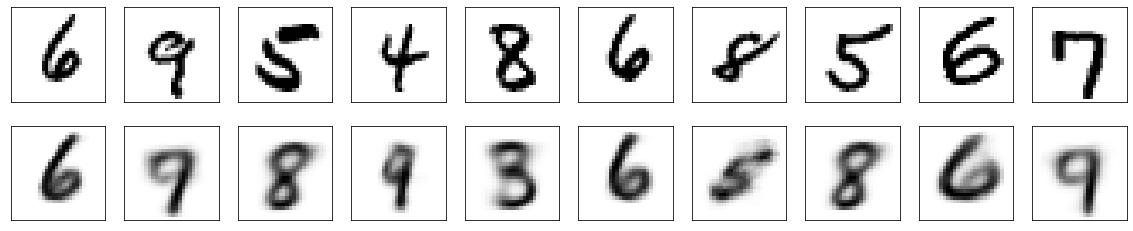

In [0]:
n_images = 10
images = iter(test_loader).next()[0]
test = images[:n_images]
with torch.no_grad():
    sample = images.to(device)
    recon_batch, _, _ = model(sample)

plt.figure(figsize=(20,4))
for (i, d) in enumerate(test):
    # テストデータのオリジナルを表示
    ax = plt.subplot(2, n_images, i+1)
    plt.imshow(d.reshape(28, 28), cmap=plt.cm.binary)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # テストデータのデコードしたものを表示
    ax = plt.subplot(2, n_images, i+1+n_images)
    plt.imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap=plt.cm.binary)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### 結果プロット用

In [0]:
def plot_encoder_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    encoder, decoder = models
    images, _ = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space

    z_mean, log_var = model.encoder(images.to(device).view(-1,784))
    z_mean = z_mean.detach().cpu().numpy()

    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
#     plt.savefig(filename)
    plt.show()

In [0]:
def plot_decoder_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]]) # decoderの入力値
            z_sample = torch.from_numpy(z_sample).to(device)
            x_decoded = model.decoder((z_sample.float()).view(1,2))
            x_decoded = x_decoded.cpu().detach().numpy()

            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
#     plt.savefig(filename)
    plt.show()

#### 結果を可視化、Encoderの結果を２次元プロット

In [0]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10000, shuffle=True, num_workers=2)
images,labels = iter(test_loader).next()
models = (encoder, decoder)
data = (images, labels)

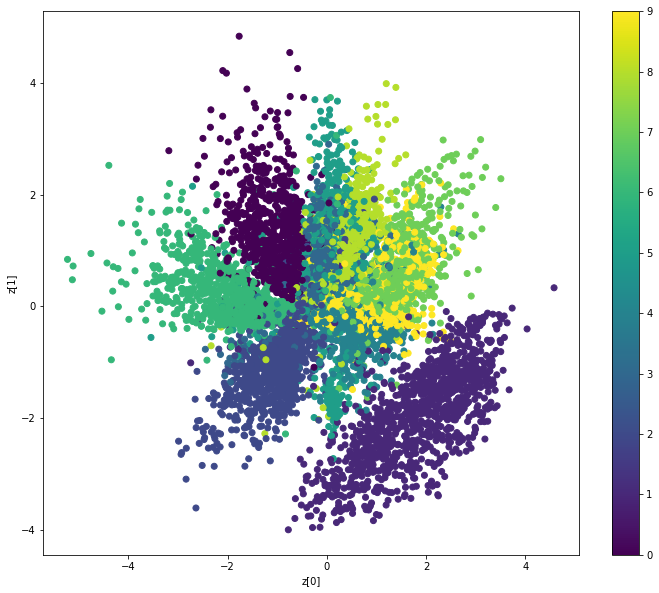

In [0]:
plot_encoder_results(models, data, batch_size=batch_size, model_name='vae_mlp')


#### Decoderで数字を生成

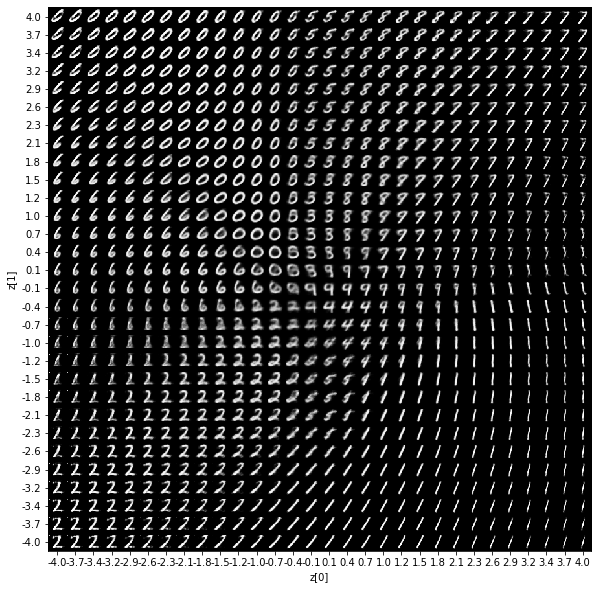

In [0]:
plot_decoder_results(models, data, batch_size=batch_size, model_name='vae_mlp')